In [18]:
import numpy as np 
from tqdm import tqdm

import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 123

In [19]:
IMG_PATH="D:\localhome\nla\Desktop\t"

TRAIN_DIR = 'CROP_TRAIN/'
VAL_DIR = 'VALIDATE/'
TEST_DIR= 'CROP_TEST/'
IMG_SIZE=(224,224)

In [20]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [21]:
# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 181.62it/s]

200 images loaded from CROP_TRAIN/ directory.
22 images loaded from CROP_TEST/ directory.
10 images loaded from VALIDATE/ directory.


In [22]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

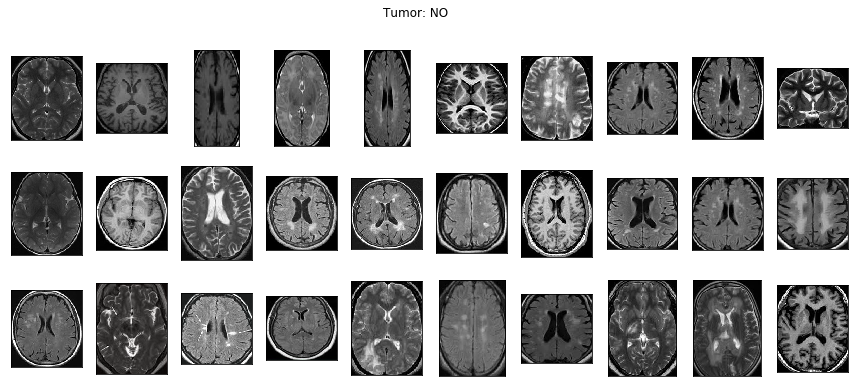

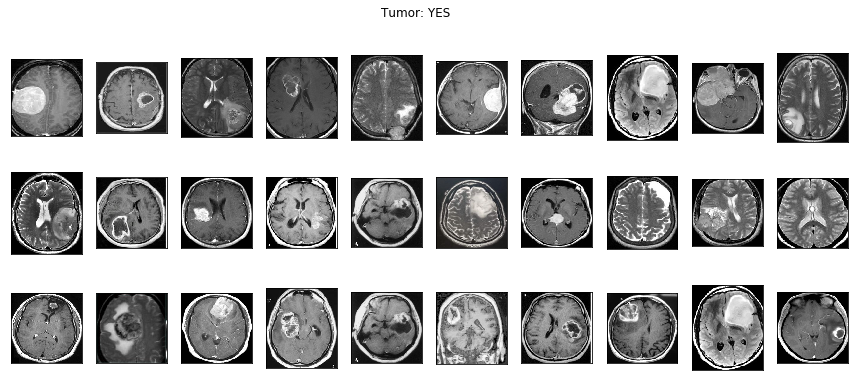

In [23]:
plot_samples(X_train, y_train, labels, 30)

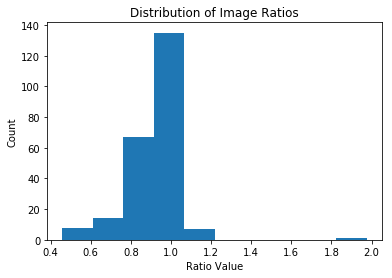

In [24]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [25]:
img = cv2.imread('D:/localhome/nla/Desktop/tumor/yes/y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

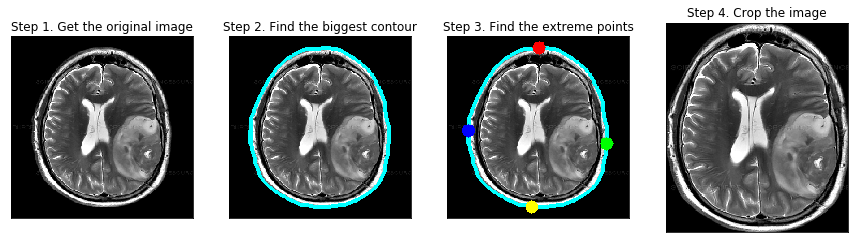

In [26]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [27]:



train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)


test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 200 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


In [28]:
# load base model
vgg16_weight_path = 'D:/localhome/nla/Desktop/tumor/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

base_model = VGG16(weights=vgg16_weight_path,include_top=False,input_shape=IMG_SIZE + (3,))

Instructions for updating:
Colocations handled automatically by placer.


In [30]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [31]:
EPOCHS = 25

es = EarlyStopping(monitor='val_acc',mode='max',patience=6)

history = model.fit_generator(generator=train_generator,steps_per_epoch=40,epochs=EPOCHS,validation_data=test_generator,
          validation_steps=20)

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
40/40 [==============================] - 516s 13s/step - loss: 2.6101 - acc: 0.7584 - val_loss: 2.2065 - val_acc: 0.8636
Epoch 2/25
40/40 [==============================] - 556s 14s/step - loss: 1.2100 - acc: 0.8788 - val_loss: 1.9372 - val_acc: 0.8636
Epoch 3/25
40/40 [==============================] - 582s 15s/step - loss: 1.2003 - acc: 0.8866 - val_loss: 2.2453 - val_acc: 0.8182
Epoch 4/25
40/40 [==============================] - 590s 15s/step - loss: 0.7689 - acc: 0.9203 - val_loss: 2.3048 - val_acc: 0.7727
Epoch 5/25
40/40 [==============================] - 588s 15s/step - loss: 0.8425 - acc: 0.9241 - val_loss: 1.7663 - val_acc: 0.8636
Epoch 6/25
40/40 [==============================] - 561s 14s/step - loss: 1.0522 - acc: 0.9150 - val_loss: 2.5817 - val_acc: 0.7727
Epoch 7/25
40/40 [==============================] - 350s 9s/step - loss: 0.5207 - acc: 0.9538 - val_loss: 1.4653 - val_acc: 0.9091
Epoch 8/25
40/40 [===========

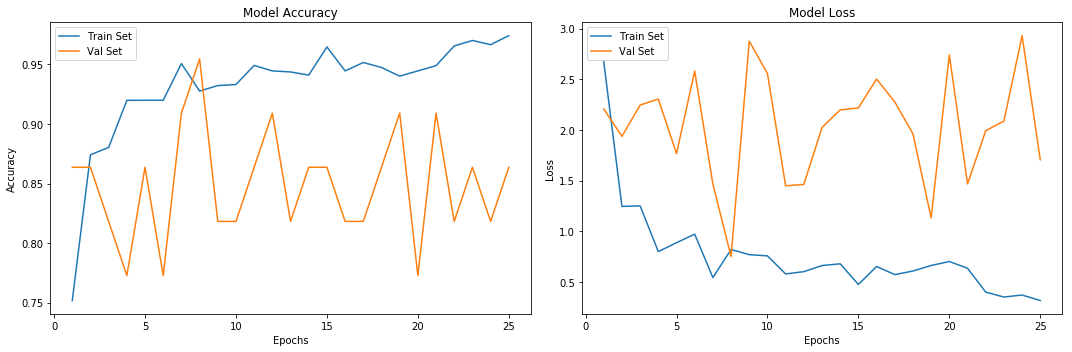

In [32]:
# plot model performance
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()